# Import Libraries (Required)

Import our essential Libraries


In [13]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, Input, Activation
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.vgg16 import VGG16

# Fetch Dataset (Required)

Some shell script to check if the data already exists, if not clone it from git.



In [14]:
%%shell

if [ ! -d '/tmp/pneumoniaDataset' ]; then 
  mkdir '/tmp/pneumoniaDataset'
fi

if [ ! -d '/tmp/pneumoniaDataset/.git' ]; then 
  git clone "https://github.com/Amzo/xray_images" '/tmp/pneumoniaDataset/'
fi

# Datasetup (Required)

Load our data and generate additional augmented data due to the nature of the small data set. Since the data is already structured into train, test and validate folders, we don't need to split the data here.


In [15]:
def getData(trainDir, testDir, valDir):
        class_names = os.listdir(trainDir)
        class_types = len(os.listdir(trainDir))

        print('Number of classes for Classification: ',class_types)
        print(f'The class names are {class_names[0]} and {class_names[1]}')
        print('--> Count of Train Images <--')

        for i in class_names:
                print(i + ':' + str(len(os.listdir(trainDir + "/" +i))))
        print('--> Count of Test Images <--')

        for i in class_names:
                print(i + ':' + str(len(os.listdir(testDir + '/' +i))))

        print('--> Count of Validation Images <---')
        for i in class_names:
                print(i + ':' + str(len(os.listdir(valDir + '/' +i))))

        train_datagen = ImageDataGenerator(rescale=1/255.0,
                rotation_range=6,
                zoom_range=0.1,
                horizontal_flip = True,
                vertical_flip = True
                )

        test_datagen = ImageDataGenerator(rescale=1./255)

        xTrainGen = train_datagen.flow_from_directory(
                trainDir,
                target_size=(224,224),
                shuffle=True,
                batch_size=24,
                class_mode='binary'
        )

        xTestGen = test_datagen.flow_from_directory(
                testDir,
                target_size=(224,224),
                batch_size=16,
                shuffle=True,
                class_mode='binary'
        )

        xValGen = train_datagen.flow_from_directory(
                valDir,
                target_size=(224,224),
                batch_size=32,
                class_mode='binary'
        )

        return xTrainGen, xTestGen, xValGen

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"


inputTrain = '/tmp/pneumoniaDataset/train'
inputTest = '/tmp/pneumoniaDataset/test'
inputValidate = '/tmp/pneumoniaDataset/val'

imageSize = (224,224,3)

xTrain, xTest, xVal = getData(inputTrain, inputTest, inputValidate)

dataSetup = True


# Data Visualisation

In [17]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:
try:
  dataIsSetup
except NameError:
  print("please execute the dataSetup section before training)
else:
  augmentedImages = [xTrain[0][0][0] for i in range(5)]

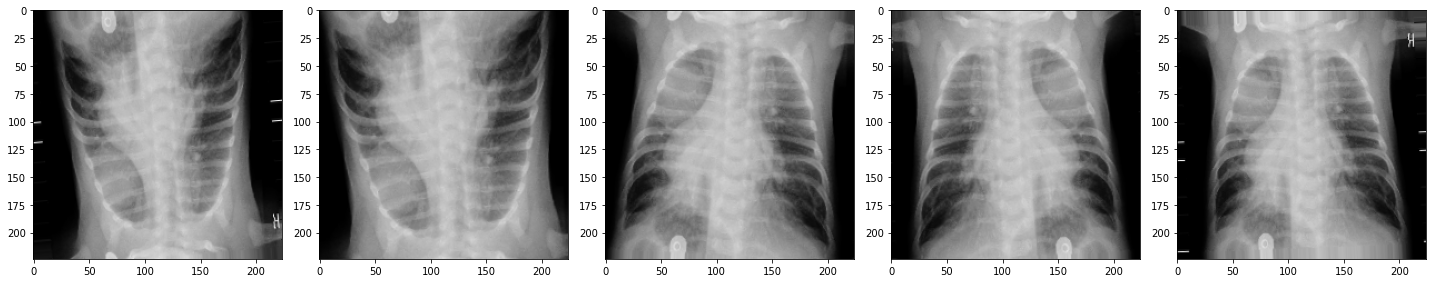

In [19]:
plotImages(augmentedImages)

# Model Setup

In [20]:
def myModel():
  print("Defaulting to basic CNN")
  model = Sequential()
  model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224,224,3)))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(Conv2D(16, (3, 3), activation='relu'))
  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid'))

  model.compile(optimizer='adam',
    loss="binary_crossentropy",
    metrics=["accuracy"])
  
  return model

Create an Exception model. This model needs a lot of resources and will not run on my system.

Using RMSprop optimiser and setting a learning rate to 0.0001. As our classification is either true or false, E.G they have something or they don't, use binary_crossentropy.


In [21]:
def modelBuild(inputShape, modelType):
  model = Sequential()
  if (modelType == "xception"):
    print("Setting up xception model")
    xception = Xception(include_top=False,
      weights= 'imagenet',
      input_shape=inputShape,
    )
    model.add(xception)

  elif (modelType == "resnet"):
    print("Setting up resnet50 model")
    resnet = ResNet50V2(include_top=False,
      weights= 'imagenet',
      input_shape=inputShape,
    )
    model.add(resnet)

  elif (modelType == "vgg16"):
    print("Setting up vgg16 model")
    vgg = VGG16(include_top=False,
      weights= 'imagenet',
      input_shape=inputShape,
    )
    model.add(vgg)
  elif (modelType == "inception"):
    print("Setting up inception model")
    inception = InceptionV3(include_top=False,
      weights= 'imagenet',
      input_shape=inputShape,
    )
    model.add(inception)

  model.add(Flatten())
  model.add(Dense(512, activation="relu"))
  model.add(Dense(1,activation="sigmoid"))

  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"])

  return model


In [ ]:
xception = modelBuild(imageSize, 'xception')
vgg16 = modelBuild(imageSize, 'vgg16')
resnet = modelBuild(imageSize, 'resnet')
inception = modelBuild(imageSize, 'inception')
myCNN = myModel()

modelsSetup = True

# Train Models

In [23]:
def modelTrain(model, xTrain, xVal, batchSize):
  model.fit(xTrain,
    epochs=10,
    validation_data=xVal,
    verbose=1,
    batch_size=batchSize
  )

  return model


In [ ]:
try:
  modelsSetup
except NameError:
  print("please execute the model Setup section before training")
else:
  trainedInception = modelTrain(inception, xTrain, xVal, 32)


I could create a function to check if the models have been setup, but you can never be certain if a cell has been executed or not, so rely on global variables being true or false. This means duplication, but it's should reduce errors.

In [ ]:
try:
  modelsSetup
except NameError:
  print("please execute the model Setup section before training")
else:
  trainedVGG = modelTrain(vgg16, xTrain, xVal, 32)


In [ ]:
try:
  modelsSetup
except NameError:
  print("please execute the model Setup section before training")
else:
  trainedResnet = modelTrain(resnet, xTrain, xVal, 32)


In [ ]:
try:
  modelsSetup
except NameError:
  print("please execute the model Setup section before training")
else:
  trainedCNN = modelTrain(myCNN, xTrain, xVal, 32)

In [ ]:
try:
  modelsSetup
except NameError:
  print("please execute the model Setup section before training")
else:
  trainedXception = modelTrain(xception, xTrain, xVal, 32)

# Save Trained Models (Optional)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
try:
  trainedInception
except NameError:
  print("Have you trained the Inception model to save?")
else:
  trainedInception.save('/content/gdrive/MyDrive/Inception')

  with open('/content/gdrive/MyDrive/inception.pickle', 'wb') as outFile:
    pickle.dump(cnnHistory.history, outFile)

In [ ]:
try:
  trainedXception
except NameError:
  print("Have you trained the Xception model to save?")
else:
  trainedXception.save('/content/gdrive/MyDrive/inception')

  with open('/content/gdrive/MyDrive/baselineHistory.pickle', 'wb') as outFile:
    pickle.dump(cnnHistory.history, outFile)

In [ ]:
try:
  trainedVGG
except NameError:
  print("Have you trained the VGG model to save?")
else:
  trainedVGG.save('/content/gdrive/MyDrive/VGG')

In [ ]:
try:
  trainedResnet
except NameError:
  print("Have you trained the resnet model to save?")
else:
  trainedResnet.save('/content/gdrive/MyDrive/Resnet')

In [ ]:
try:
  trainedCNN
except NameError:
  print("Have you trained myCNN model to save?")
else:
  trainedCNN.save('/content/gdrive/MyDrive/myCNN')

# Test Models

In [ ]:
print("Running Xception model against test set")
ev = trainedXception.evaluate(xTest)
print("\n%s: %.f%%" % (trainedXception.metrics_names[1], ev[1]*100))
print("Running VGG16 model against test set")
ev = trainedVGG.evaluate(xTest)
print("\n%s: %.f%%" % (trainedVGG.metrics_names[1], ev[1]*100))
print("Running resnet model against test set")
ev = trainedResnet.evaluate(xTest)
print("\n%s: %.f%%" % (trainedResnet.metrics_names[1], ev[1]*100))
print("Running myCNN model against test set")
ev = trainedCNN.evaluate(xTest)
print("\n%s: %.f%%" % (trainedCNN.metrics_names[1], ev[1]*100))